In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('stopwords')

np.random.seed(42)


2024-12-17 00:11:38.985161: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 00:11:39.225251: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 00:11:39.356394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734394299.635246    7202 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734394299.700091    7202 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 00:11:40.340718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:

data = {
    'customer_transcription': [
        "I want to know the status of my complaint.",
        "Why hasn't my issue been resolved yet?",
        "Thank you for solving my problem quickly!",
        "This is the third time I'm calling about this!",
        "Can I get an update on my request?",
    ] * 100,
    
    'attendant_transcription': [
        "Your issue is being processed and will be resolved soon.",
        "We apologize for the delay in resolving your issue.",
        "I'm glad to hear that your problem was resolved.",
        "Let me transfer you to the relevant department.",
        "Your request is currently under review.",
    ] * 100,
    
    'is_solved': np.random.choice([0, 1], size=500, p=[0.8, 0.2])  # Imbalanced target
}

df = pd.DataFrame(data)



In [3]:

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = unidecode(text)  # Remove accents
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
    tokens = text.split()  # Tokenize by whitespace
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # Remove stopwords and stem
    return ' '.join(tokens)

df['customer_transcription'] = df['customer_transcription'].apply(preprocess_text)
df['attendant_transcription'] = df['attendant_transcription'].apply(preprocess_text)



In [20]:
max_features = 200

def create_vectorizer():
    return TextVectorization(
        max_tokens=max_features,
        ngrams=2,
        output_mode='tf_idf' )





In [21]:
customer_vectorizer = create_vectorizer()
attendant_vectorizer = create_vectorizer()

2024-12-17 00:16:42.929507: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [22]:

customer_vectorizer.adapt(df['customer_transcription'])
attendant_vectorizer.adapt(df['attendant_transcription'])

X_customer = customer_vectorizer(df['customer_transcription']).numpy()
X_attendant = attendant_vectorizer(df['attendant_transcription']).numpy()

In [23]:
X = np.hstack([X_customer, X_attendant])
y = df['is_solved']



In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"Calculated scale_pos_weight: {scale_pos_weight}")

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)



Calculated scale_pos_weight: 3.72972972972973


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:17:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [25]:

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


=== Confusion Matrix ===
[[70 48]
 [20 12]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       118
           1       0.20      0.38      0.26        32

    accuracy                           0.55       150
   macro avg       0.49      0.48      0.47       150
weighted avg       0.65      0.55      0.59       150


ROC-AUC: 0.4772


In [26]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = unidecode(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
from textblob import TextBlob

df['customer_sentiment'] = df['customer_transcription'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['attendant_sentiment'] = df['attendant_transcription'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [28]:
!pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 21.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [30]:
resolution_keywords = ['resolved', 'solved', 'fixed', 'thank']
complaint_keywords = ['delay', 'issue', 'problem', 'calling']

df['customer_resolution_flag'] = df['customer_transcription'].apply(lambda x: any(word in x for word in resolution_keywords))
df['customer_complaint_flag'] = df['customer_transcription'].apply(lambda x: any(word in x for word in complaint_keywords))


In [34]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


ModuleNotFoundError: No module named 'imblearn'

In [36]:
!pip install imblearn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [37]:
from imblearn.over_sampling import SMOTE
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_res, y_train_res)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)

[I 2024-12-17 00:24:49,712] A new study created in memory with name: no-name-5e72e0c9-4c9d-435b-a78b-e83c51cbd0e4
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:24:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-17 00:24:49,840] Trial 0 finished with value: 0.4772245762711864 and parameters: {'max_depth': 7, 'learning_rate': 0.013708834819499329, 'n_estimators': 206, 'scale_pos_weight': 5.1051420557951985, 'subsample': 0.6662316264874427, 'colsample_bytree': 0.6989353158761906}. Best is trial 0 with value: 0.4772245762711864.
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:24:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-17 00:24:49,892] Trial 1 finished with value: 0.4772245762711864 and parameters: {'max_depth

Best Parameters: {'max_depth': 3, 'learning_rate': 0.22577762093981374, 'n_estimators': 453, 'scale_pos_weight': 4.264074421780372, 'subsample': 0.6302201811429237, 'colsample_bytree': 0.5935637218376407}


In [32]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 21.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [38]:
from sklearn.metrics import precision_recall_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

optimal_threshold = thresholds[np.argmax(recall - precision)]
print(f"Optimal Threshold: {optimal_threshold}")

y_pred = (y_pred_proba >= optimal_threshold).astype(int)


Optimal Threshold: 0.4398846924304962


In [39]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Initialize the model with the best parameters
best_params = {
    'max_depth': 3,
    'learning_rate': 0.22577762093981374,
    'n_estimators': 453,
    'scale_pos_weight': 4.264074421780372,
    'subsample': 0.6302201811429237,
    'colsample_bytree': 0.5935637218376407
}

model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:25:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Confusion Matrix ===
[[  0 118]
 [  0  32]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       118
           1       0.21      1.00      0.35        32

    accuracy                           0.21       150
   macro avg       0.11      0.50      0.18       150
weighted avg       0.05      0.21      0.08       150


ROC-AUC: 0.5058


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Apply Random Undersampling instead of SMOTE
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Update model with reduced scale_pos_weight and increased max_depth
model = XGBClassifier(
    max_depth=4,
    learning_rate=0.2258,
    n_estimators=500,
    scale_pos_weight=1.5,  # Reduced scale_pos_weight
    subsample=0.63,
    colsample_bytree=0.59,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_res, y_train_res)

# Predictions with threshold tuning
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.6  # Adjust threshold based on results
y_pred = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


=== Confusion Matrix ===
[[45 73]
 [14 18]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.76      0.38      0.51       118
           1       0.20      0.56      0.29        32

    accuracy                           0.42       150
   macro avg       0.48      0.47      0.40       150
weighted avg       0.64      0.42      0.46       150


ROC-AUC: 0.4529


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:26:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [41]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Train Balanced Random Forest
model = BalancedRandomForestClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


/usr/local/python/3.12.1/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future 

=== Confusion Matrix ===
[[43 75]
 [14 18]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.36      0.49       118
           1       0.19      0.56      0.29        32

    accuracy                           0.41       150
   macro avg       0.47      0.46      0.39       150
weighted avg       0.63      0.41      0.45       150


ROC-AUC: 0.4772


In [42]:
from textblob import TextBlob

df['customer_sentiment'] = df['customer_transcription'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['attendant_sentiment'] = df['attendant_transcription'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [43]:
resolution_keywords = ['resolved', 'solved', 'fixed', 'thank']
complaint_keywords = ['delay', 'issue', 'problem', 'calling']

df['customer_resolution_flag'] = df['customer_transcription'].apply(lambda x: any(word in x for word in resolution_keywords))
df['customer_complaint_flag'] = df['customer_transcription'].apply(lambda x: any(word in x for word in complaint_keywords))


In [44]:
from sklearn.metrics import precision_recall_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

optimal_idx = np.argmax(recall - precision)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

y_pred = (y_pred_proba >= optimal_threshold).astype(int)


Optimal Threshold: 0.4454796932442188


In [46]:
# Create customer_length and attendant_length columns
df['customer_length'] = df['customer_transcription'].apply(lambda x: len(x.split()))
df['attendant_length'] = df['attendant_transcription'].apply(lambda x: len(x.split()))


In [47]:
# Add new features
df['customer_sentiment'] = df['customer_transcription'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['attendant_sentiment'] = df['attendant_transcription'].apply(lambda x: TextBlob(x).sentiment.polarity)

resolution_keywords = ['resolved', 'solved', 'fixed', 'thank']
complaint_keywords = ['delay', 'issue', 'problem', 'calling']

df['customer_resolution_flag'] = df['customer_transcription'].apply(lambda x: any(word in x for word in resolution_keywords))
df['customer_complaint_flag'] = df['customer_transcription'].apply(lambda x: any(word in x for word in complaint_keywords))

# Combine features
X = np.hstack([
    X_customer, 
    X_attendant, 
    df[['customer_length', 'attendant_length', 'customer_sentiment', 'attendant_sentiment', 'customer_resolution_flag', 'customer_complaint_flag']].values
])
y = df['is_solved']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


=== Confusion Matrix ===
[[70 48]
 [20 12]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       118
           1       0.20      0.38      0.26        32

    accuracy                           0.55       150
   macro avg       0.49      0.48      0.47       150
weighted avg       0.65      0.55      0.59       150


ROC-AUC: 0.4772


In [49]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


best_params = {
    'max_depth': 3,
    'learning_rate': 0.22577762093981374,
    'n_estimators': 453,
    'scale_pos_weight': 4.264074421780372,
    'subsample': 0.6302201811429237,
    'colsample_bytree': 0.5935637218376407
}

model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


=== Confusion Matrix ===
[[43 75]
 [14 18]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.36      0.49       118
           1       0.19      0.56      0.29        32

    accuracy                           0.41       150
   macro avg       0.47      0.46      0.39       150
weighted avg       0.63      0.41      0.45       150


ROC-AUC: 0.4772


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:30:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [53]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)


In [54]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(class_weight='balanced', n_estimators=500, random_state=42)
model.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 276, number of negative: 276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

LGBMClassifier(class_weight='balanced', n_estimators=500, random_state=42)

In [52]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [55]:
from sklearn.metrics import precision_recall_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

optimal_idx = np.argmax(recall - precision)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

y_pred = (y_pred_proba >= optimal_threshold).astype(int)


Optimal Threshold: 0.4411764593530244


In [56]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(**best_params, use_label_encoder=False)),
        ('lgbm', LGBMClassifier(class_weight='balanced', n_estimators=500)),
        ('lr', LogisticRegression(class_weight='balanced', max_iter=1000))
    ],
    voting='soft'
)

ensemble_model.fit(X_train_res, y_train_res)
y_pred = ensemble_model.predict(X_test)


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:41:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 276, number of negative: 276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

=== Confusion Matrix ===
[[  0 118]
 [  0  32]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       118
           1       0.21      1.00      0.35        32

    accuracy                           0.21       150
   macro avg       0.11      0.50      0.18       150
weighted avg       0.05      0.21      0.08       150


ROC-AUC: 0.4772


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


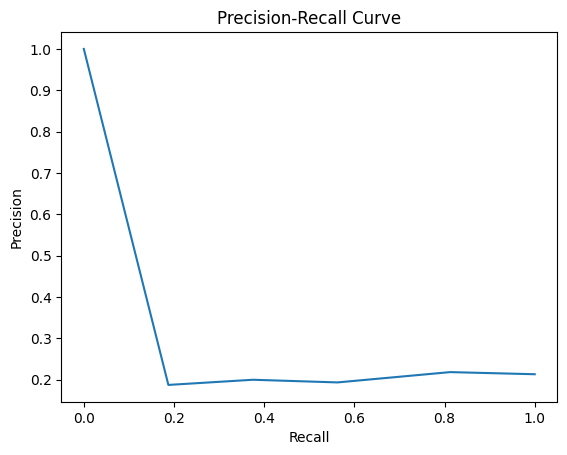


Matthews Correlation Coefficient: 0.0000
Cohen's Kappa: 0.0000


In [57]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    matthews_corrcoef,
    cohen_kappa_score
)
import matplotlib.pyplot as plt

# Confusion Matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC: {roc_auc:.4f}")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"\nMatthews Correlation Coefficient: {mcc:.4f}")

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")
